In [1]:
import pandas as pd
import plotly.express as px
import shapely
import math
import random
import geopandas as gp
from scipy import optimize

# Simulating Advertisement Effect on Tourism Trends in South Tyrol 

### Visualize The District Similarity Matrix

In [2]:
similarities_named = pd.read_csv('../data/similarities.csv', index_col=0)
similarities = pd.read_csv('../data/similarities_indexed.csv', index_col=0)

In [3]:
similarities_named

,Bozen,Burggrafenamt,Eisacktal,Pustertal,Salten-Schlern,Uberetsch-Unterland,Vinschgau,Wipptal
Bozen,1.000000,0.313622,0.268370,0.230376,0.191954,0.492863,0.094884,0.090922
Burggrafenamt,0.313622,1.000000,0.812024,0.837530,0.784293,0.829108,0.679950,0.450493
Eisacktal,0.268370,0.812024,1.000000,0.836409,0.812596,0.824922,0.876415,0.792500
Pustertal,0.230376,0.837530,0.836409,1.000000,0.889820,0.676141,0.698338,0.532867
Salten-Schlern,0.191954,0.784293,0.812596,0.889820,1.000000,0.697456,0.721487,0.553111
Uberetsch-Unterland,0.492863,0.829108,0.824922,0.676141,0.697456,1.000000,0.717645,0.540560
Vinschgau,0.094884,0.679950,0.876415,0.698338,0.721487,0.717645,1.000000,0.890124
Wipptal,0.090922,0.450493,0.792500,0.532867,0.553111,0.540560,0.890124,1.000000


### Helper structures

In [4]:
district_code_map = {1: "Bozen", 2: "Burggrafenamt", 3: "Eisacktal", 4: "Pustertal", 5: "Salten-Schlern", 6: "Uberetsch-Unterland", 7: "Vinschgau", 8: "Wipptal"}

In [5]:
def printAdvertisements(destinations):
    print("Generated Advertisement: \n")
    for index, el in enumerate(destinations):
        print('Item', index+1, ": ",district_code_map[el])
    print("\n")

In [6]:
def formatProbabilities(probabilities):
    print("Selection Probabilities: \n")
    for key in probabilities:
        print(district_code_map[key], probabilities[key]*100, "%")

### Define Simulation Parameters

In [7]:
# Simulation Parameters

ADVERTISEMENT_SIZE = 4
SIMULATION_YEAR = 2019
SIMULATION_STRATEGY = "TOPN"
SEEN_RATE = 1

# Additional Assumptions

AD_CONV_RATE = 0.375
DECAY_RATE = 1.2
CHOICE_UTILITY = 5

### Utility and Probability Computation Functions

In [8]:
def getUtilities(advertisement, userChoice, conv_rate = -1):

    utilities = {userChoice: CHOICE_UTILITY}

    for index, d in enumerate(advertisement):
        if not d in utilities:
            utility = similarities[str(userChoice)].loc[d]*CHOICE_UTILITY/(DECAY_RATE**index) 
            utilities[d] = utility 
        
    if not conv_rate == -1:
        k = getK(utilities, userChoice, conv_rate)
        for key in utilities:
            if not key == userChoice:
                utilities[key] = utilities[key] * k
        
    return utilities

In [9]:
def getProbabilities(utilities):
    
    elSum = 0
    probabilities = {}
    
    for uKey in utilities:
        elSum = elSum + math.exp(utilities[uKey])
    
    for uKey in utilities:
        probabilities[uKey] = math.exp(utilities[uKey])/elSum
        
    return probabilities

In [10]:
def getK(utilities, user_choice, conv_rate):
    
    def func(x):
        
        total = 0
        
        for key in utilities:
            if not key == user_choice:
                total = total + math.exp(utilities[key]*x)
            
        return total - (math.exp(5)/(1 - conv_rate) - math.exp(5))

    sol = optimize.root_scalar(func, bracket=[0,10.], method='brentq')
    x = sol.root

    return x

In [11]:
def getUtilitiesWithConvertionRate(advertisement, userChoice):

    utilities = {}

    for index, d in enumerate(advertisement):
        utility = similarities[str(userChoice)].loc[d]*CHOICE_UTILITY/(DECAY_RATE**index) 
        utilities[d] = utility 
        
    return utilities

In [12]:
def getProbabilitiesWithConvertionRate(utilities, userChoice, conv_rate):
    
    elSum = 0
    probabilities = {}
    
    for uKey in utilities:
        elSum = elSum + math.exp(utilities[uKey])
    
    for uKey in utilities:
        probabilities[uKey] = math.exp(utilities[uKey])/elSum*conv_rate
        
    if userChoice in probabilities:
        probabilities[userChoice] = probabilities[userChoice] + (1 - conv_rate)
    else:
        probabilities[userChoice] = 1 - conv_rate
        
    return probabilities

### Generate Advertisement

In [13]:
arrivalCounts = pd.read_csv("../data/districts_ranked.csv")

In [14]:
def generateAdvertisement(strategy, size, year):
    
    df = arrivalCounts[arrivalCounts['Year'] == year]
    
    if strategy == 'TOPN':
        return df['district_c'].head(size).tolist()
    if strategy == 'LEASTN':
        return df.sort_values(by='Rank', ascending=False)['district_c'].head(size).tolist()
    return random.sample(range(1, 9),size)
    

### Simulate Advertisement Effect (Single User)

In [15]:
DESTINATION_ADVERTISEMENT = generateAdvertisement('TOPN', 3, 2019) 
printAdvertisements(DESTINATION_ADVERTISEMENT)

# district_code_map = {1: "Bozen", 2: "Burggrafenamt", 3: "Eisacktal", 4: "Pustertal", 5: "Salten-Schlern",
# 6: "Uberetsch-Unterland", 7: "Vinschgau", 8: "Wipptal"}

USER_CHOICE = 3

utilities = getUtilities(DESTINATION_ADVERTISEMENT, USER_CHOICE)

probabilities = getProbabilities(utilities)

formatProbabilities(probabilities)
#formatProbabilities(utilities)

Generated Advertisement: 

Item 1 :  Pustertal
Item 2 :  Burggrafenamt
Item 3 :  Salten-Schlern


Selection Probabilities: 

Eisacktal 57.040993331013354 %
Pustertal 25.174093957951865 %
Burggrafenamt 11.327149274352942 %
Salten-Schlern 6.457763436681844 %


### Simulate Advertisement Effecr with Conversion Rate and K

In [16]:
DESTINATION_ADVERTISEMENT = generateAdvertisement('TOPN', 3, 2019) 
printAdvertisements(DESTINATION_ADVERTISEMENT)

# district_code_map = {1: "Bozen", 2: "Burggrafenamt", 3: "Eisacktal", 4: "Pustertal", 5: "Salten-Schlern",
# 6: "Uberetsch-Unterland", 7: "Vinschgau", 8: "Wipptal"}

USER_CHOICE = 3

utilities = getUtilities(DESTINATION_ADVERTISEMENT, USER_CHOICE, 0.375)
        
probabilities = getProbabilities(utilities)

# # formatProbabilities(probabilities)
formatProbabilities(probabilities)

Generated Advertisement: 

Item 1 :  Pustertal
Item 2 :  Burggrafenamt
Item 3 :  Salten-Schlern


Selection Probabilities: 

Eisacktal 62.499999999995104 %
Pustertal 21.41951332703664 %
Burggrafenamt 10.11465646263365 %
Salten-Schlern 5.965830210334615 %


### Simulate Advertisement Effect with Conversion Rate (Single User)

In [17]:
DESTINATION_ADVERTISEMENT = generateAdvertisement('TOPN', 3, 2019) 
printAdvertisements(DESTINATION_ADVERTISEMENT)

# district_code_map = {1: "Bozen", 2: "Burggrafenamt", 3: "Eisacktal", 4: "Pustertal", 5: "Salten-Schlern",
# 6: "Uberetsch-Unterland", 7: "Vinschgau", 8: "Wipptal"} 

USER_CHOICE = 3
AD_CONV_RATE = 0.375

utilities = getUtilitiesWithConvertionRate(DESTINATION_ADVERTISEMENT, USER_CHOICE)

probabilities = getProbabilitiesWithConvertionRate(utilities, USER_CHOICE, AD_CONV_RATE)

formatProbabilities(probabilities)

Generated Advertisement: 

Item 1 :  Pustertal
Item 2 :  Burggrafenamt
Item 3 :  Salten-Schlern


Selection Probabilities: 

Pustertal 21.97510130290597 %
Burggrafenamt 9.88775418065911 %
Salten-Schlern 5.637144516434918 %
Eisacktal 62.5 %


In [71]:
def getSustainableForDistrict(district, k, dataframe, column):
    similaritiesForDistrict = similarities[str(district)].sort_values(ascending=False)
    # print(similaritiesForDistrict)
    sustainableItems = dataframe.sort_values(by=column, ascending=True)['district_c'].head(4).tolist()
    print(sustainableItems)
    sustainableAd = []
    for index, row in similaritiesForDistrict.items():
        if index != district:
            if index in sustainableItems:
                sustainableAd.append(index)
            if len(sustainableAd) == 2:
                return sustainableAd
    return sustainableAd

arrivalCounts = pd.read_csv("../data/districts_ranked.csv")
ac = arrivalCounts[arrivalCounts['Year'] == 2019]
# similarities
adDictionary = {}
for i in range(1, 9):
    adDictionary[i] = getSustainableForDistrict(i, 2, ac, 'Arrivals')
print(adDictionary)

# district_code_map = {1: "Bozen", 2: "Burggrafenamt", 3: "Eisacktal", 4: "Pustertal", 5: "Salten-Schlern",
# 6: "Uberetsch-Unterland", 7: "Vinschgau", 8: "Wipptal"}


[1, 8, 6, 7]
[1, 8, 6, 7]
[1, 8, 6, 7]
[1, 8, 6, 7]
[1, 8, 6, 7]
[1, 8, 6, 7]
[1, 8, 6, 7]
[1, 8, 6, 7]
{1: [6, 7], 2: [6, 7], 3: [7, 6], 4: [7, 6], 5: [7, 6], 6: [7, 8], 7: [8, 6], 8: [7, 6]}


In [70]:
pd.read_csv("../data/districts_ranked.csv")

,Year,district_c,Month,Unnamed: 0,Arrivals,Present,Rank
0,2010,4,78.0,7040583,1637302,8811217,1.0
1,2010,2,78.0,6556830,1182136,6382967,2.0
2,2010,5,78.0,3619091,888550,5050970,3.0
3,2010,3,78.0,3371868,556041,2493437,4.0
4,2010,6,78.0,4542618,444038,1985721,5.0
...,...,...,...,...,...,...,...
83,2020,3,78.0,60932263,454460,1956092,4.0
84,2020,7,78.0,64621885,373635,1630481,5.0
85,2020,6,78.0,81331888,280957,1267125,6.0
86,2020,8,78.0,31277832,251566,911089,7.0


### Simulate for A Whole Year

In [18]:
# Load the Nationalities Dataframe
arrivals = pd.read_csv('../data/nationality_trends.csv')

In [20]:
# Filter for the Simulation Year
arrivals = arrivals[arrivals['Year'] == SIMULATION_YEAR]

In [21]:
# Make Dataset Long
arrivals = pd.pivot(arrivals, index=['Year', 'Month', 'district_c', 'Season'], columns=['Nationality'], values='Arrivals').reset_index()
arrivals.head(5)

Nationality,Year,Month,district_c,Season,Austria,Benelux countries,Germany,Italy,Other countries,Switzerland and Liechtenstein
0,2019,1.0,1,Winter,681,161,1796,14005,2556,240
1,2019,1.0,2,Winter,1045,212,7592,21583,2047,1331
2,2019,1.0,3,Winter,1517,693,24170,19688,4993,1157
3,2019,1.0,4,Winter,5148,4791,72654,104739,49319,2951
4,2019,1.0,5,Winter,2411,6059,32685,45237,28584,2998


In [22]:
# Get Rid of Null Values 

arrivals['Austria'] = arrivals['Austria'].fillna(0)
arrivals['Benelux countries'] = arrivals['Benelux countries'].fillna(0)
arrivals['Germany'] = arrivals['Germany'].fillna(0)
arrivals['Italy'] = arrivals['Italy'].fillna(0)
arrivals['Other countries'] = arrivals['Other countries'].fillna(0)
arrivals['Switzerland and Liechtenstein'] = arrivals['Switzerland and Liechtenstein'].fillna(0)

In [23]:
# Sum Arrivals of Diff Nationalities

arrivals['Arrivals']= arrivals['Austria'] + arrivals['Benelux countries'] + arrivals['Germany'] + arrivals['Italy'] + arrivals['Other countries'] + arrivals['Switzerland and Liechtenstein']

In [24]:
# Visualise The Dataframe

arrivals.head(5)

Nationality,Year,Month,district_c,Season,Austria,Benelux countries,Germany,Italy,Other countries,Switzerland and Liechtenstein,Arrivals
0,2019,1.0,1,Winter,681,161,1796,14005,2556,240,19439
1,2019,1.0,2,Winter,1045,212,7592,21583,2047,1331,33810
2,2019,1.0,3,Winter,1517,693,24170,19688,4993,1157,52218
3,2019,1.0,4,Winter,5148,4791,72654,104739,49319,2951,239602
4,2019,1.0,5,Winter,2411,6059,32685,45237,28584,2998,117974


In [25]:
DESTINATION_ADVERTISEMENT = generateAdvertisement('TOPN', 3, 2019)
printAdvertisements(DESTINATION_ADVERTISEMENT)

Generated Advertisement: 

Item 1 :  Pustertal
Item 2 :  Burggrafenamt
Item 3 :  Salten-Schlern




In [26]:
arrivals = pd.read_csv('../data/nationality_long.csv')
arrivals = arrivals[arrivals['Year'] == SIMULATION_YEAR]

### SIMULATION WITHOUT NATIONALITY INFO

In [127]:
import time
startTime = time.time()

arrivalsDf = arrivals

# construct a new dataframe
df = pd.DataFrame(columns=['Year', 'Month', 'Season', 'district_c', 'District', 'Arrivals'])
nationalities = ['Austria', 'Benelux countries', 'Germany', 'Italy', 'Other countries', 'Switzerland and Liechtenstein']

nonArrivals = arrivalsDf.copy()
arrivalsDf[['Arrivals']] = arrivalsDf[['Arrivals']].multiply(0.9).round()

nonArrivals[['Arrivals']] = nonArrivals[['Arrivals']] - arrivalsDf[['Arrivals']]

utilityMap = {}
for index in range(1, 9):
    utilityMap[index] = getUtilities(DESTINATION_ADVERTISEMENT, index, 0.375)
    
for i, row in arrivalsDf.iterrows():
   
    utilities = utilityMap[row['district_c']]#getUtilities(DESTINATION_ADVERTISEMENT, row['district_c'], 0.375)
    probabilities = getProbabilities(utilities)

    elements = list(probabilities.keys())
    
    choices = random.choices(elements, weights=list(probabilities.values()), k=int(row['Arrivals']))
    
    start = [row['Year'], row['Month'], row['Season']]
    
    s_row = pd.Series(start + [nonArrivals.loc[i, 'district_c']] + [district_code_map[nonArrivals.loc[i, 'district_c']]] + [nonArrivals.loc[i, "Arrivals"]], index=df.columns)
    df = df.append(s_row,ignore_index=True)

    for dist in range(1, 9):
        #df.loc[len(df.index)] = start + [nat] + [dist] + [district_code_map[dist]] + [natChoices.count(dist)]

        s_row = pd.Series(start + [dist] + [district_code_map[dist]] + [choices.count(dist)], index=df.columns)
        df = df.append(s_row,ignore_index=True)

        
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 3.4051241874694824


### SIMULATION WITH NATIONALITY INFO

In [131]:
import time
startTime = time.time()

arrivalsDf = arrivals

# construct a new dataframe
df = pd.DataFrame(columns=['Year', 'Month', 'Season', 'Nationality', 'district_c', 'District', 'Arrivals'])
nationalities = ['Austria', 'Benelux countries', 'Germany', 'Italy', 'Other countries', 'Switzerland and Liechtenstein']

nonArrivals = arrivalsDf.copy()
arrivalsDf[['Austria', 'Benelux countries', 'Germany', 'Italy', 'Other countries', 'Switzerland and Liechtenstein', 'Arrivals']] = arrivalsDf[['Austria', 'Benelux countries', 'Germany', 'Italy', 'Other countries', 'Switzerland and Liechtenstein', 'Arrivals']].multiply(0.9).round()

nonArrivals[['Austria', 'Benelux countries', 'Germany', 'Italy', 'Other countries', 'Switzerland and Liechtenstein', 'Arrivals']] = nonArrivals[['Austria', 'Benelux countries', 'Germany', 'Italy', 'Other countries', 'Switzerland and Liechtenstein', 'Arrivals']] - arrivalsDf[['Austria', 'Benelux countries', 'Germany', 'Italy', 'Other countries', 'Switzerland and Liechtenstein', 'Arrivals']]

utilityMap = {}
for index in range(1, 9):
    utilityMap[index] = getUtilities(DESTINATION_ADVERTISEMENT, index, 0.375)
    
for i, row in arrivalsDf.iterrows():
   
    utilities = utilityMap[row['district_c']]#getUtilities(DESTINATION_ADVERTISEMENT, row['district_c'], 0.375)
    probabilities = getProbabilities(utilities)

    elements = list(probabilities.keys())
    
    choices = random.choices(elements, weights=list(probabilities.values()), k=int(row['Arrivals']))
    
    start = [row['Year'], row['Month'], row['Season']]
    
    for nat in nationalities:
        
        natCount = int(row[nat])
            
        natChoices = choices[0:natCount]
        choices = choices[natCount:]
        
        s_row = pd.Series(start + [nat] + [nonArrivals.loc[i, 'district_c']] + [district_code_map[nonArrivals.loc[i, 'district_c']]] + [nonArrivals.loc[i, nat]], index=df.columns)
        df = df.append(s_row,ignore_index=True)
        
        for dist in range(1, 9):
            #df.loc[len(df.index)] = start + [nat] + [dist] + [district_code_map[dist]] + [natChoices.count(dist)]
            
            s_row = pd.Series(start + [nat] + [dist] + [district_code_map[dist]] + [natChoices.count(dist)], index=df.columns)
            df = df.append(s_row,ignore_index=True)
            
            # print(nonArrivals.loc[i, nat])
            
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))

Execution time in seconds: 13.029198408126831


In [115]:
simulatedResults = df.groupby(by=['Year', 'Month', 'Season', 'Nationality', 'district_c', 'District']).sum().reset_index()

simulatedResults.to_csv('../data/sim.csv', index=False)

arrivals2 = pd.read_csv('../data/nationality_trends.csv')
arrivals2 = arrivals2[arrivals2['Year'] == SIMULATION_YEAR]

arrivals2 = arrivals2.merge(simulatedResults, how='inner', on=["Year", "Month", "district_c", "Nationality"], suffixes=("", "_sim"))
arrivals2 = arrivals2.drop(['Season_sim'], axis = 1)
arrivals2['Diff'] = arrivals2['Arrivals_sim'] - arrivals2['Arrivals']
arrivals2

,Year,Month,Nationality,district_c,Season,Arrivals,Present,District,Arrivals_sim,Diff
0,2019,1.0,Austria,1,Winter,681,1233,Bozen,463.0,-218.0
1,2019,1.0,Austria,2,Winter,1045,3478,Burggrafenamt,2313.0,1268.0
2,2019,1.0,Austria,3,Winter,1517,4422,Eisacktal,1032.0,-485.0
3,2019,1.0,Austria,4,Winter,5148,20742,Pustertal,5082.0,-66.0
4,2019,1.0,Austria,5,Winter,2411,10241,Salten-Schlern,2541.0,130.0
...,...,...,...,...,...,...,...,...,...,...
571,2019,12.0,Switzerland and Liechtenstein,4,Winter,2775,11304,Pustertal,4497.0,1722.0
572,2019,12.0,Switzerland and Liechtenstein,5,Winter,2611,11074,Salten-Schlern,2669.0,58.0
573,2019,12.0,Switzerland and Liechtenstein,6,Winter,792,2310,Uberetsch-Unterland,536.0,-256.0
574,2019,12.0,Switzerland and Liechtenstein,7,Winter,1811,6827,Vinschgau,1198.0,-613.0


### Visualize the Results

#### By District

In [116]:
visualizeOverall = arrivals2

In [117]:
arrivals2.head(10)

,Year,Month,Nationality,district_c,Season,Arrivals,Present,District,Arrivals_sim,Diff
0,2019,1.0,Austria,1,Winter,681,1233,Bozen,463.0,-218.0
1,2019,1.0,Austria,2,Winter,1045,3478,Burggrafenamt,2313.0,1268.0
2,2019,1.0,Austria,3,Winter,1517,4422,Eisacktal,1032.0,-485.0
3,2019,1.0,Austria,4,Winter,5148,20742,Pustertal,5082.0,-66.0
4,2019,1.0,Austria,5,Winter,2411,10241,Salten-Schlern,2541.0,130.0
5,2019,1.0,Austria,6,Winter,334,665,Uberetsch-Unterland,222.0,-112.0
6,2019,1.0,Austria,7,Winter,605,1933,Vinschgau,401.0,-204.0
7,2019,1.0,Austria,8,Winter,934,2707,Wipptal,621.0,-313.0
8,2019,1.0,Benelux countries,1,Winter,161,312,Bozen,104.0,-57.0
9,2019,1.0,Benelux countries,2,Winter,212,1597,Burggrafenamt,1854.0,1642.0


In [119]:
## FILTER BY MONTH
#visualizeOverall = visualizeOverall[visualizeOverall['Month'] == 1]

## FILTER BY NAT
# visualizeOverall = visualizeOverall[visualizeOverall['Nationality'] == 'Germany']

visualizeOverall = visualizeOverall.groupby(["district_c"]).sum().reset_index()

In [122]:
districts = gp.read_file('../data/geo_district_df.shp')
    
visualizeOverallMap = districts.merge(visualizeOverall, on='district_c',
                              how="inner", suffixes=('', '_y'))

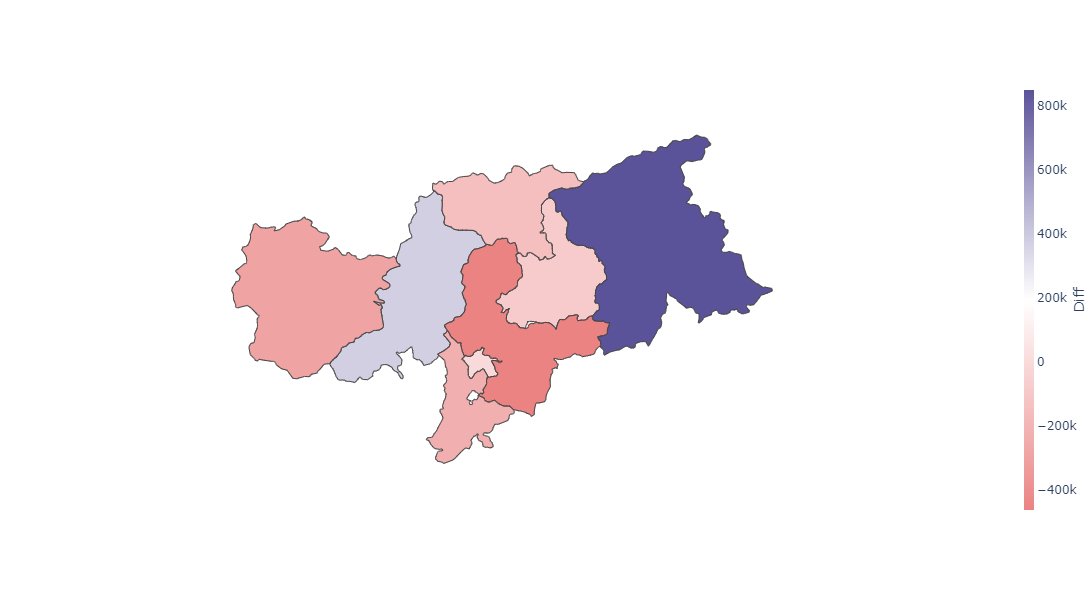

In [124]:
color_scale = ['#eb8383', "#ffffff", '#5b5399']

target = 'Diff'
df = visualizeOverallMap

df['Rank'] = df[target].rank(ascending=False)

df['Name'] = df[['district_i', 'district_g']].apply(
        lambda x: ' /\n'.join(x), axis=1)

df = df.round(2)

vmin = df[target].min()
vmax = df[target].max()

figM = px.choropleth(df,
                    geojson=df.geometry,
                    color=f'{target}',
                    projection='mercator',
                    color_continuous_scale=color_scale,
                    range_color=[vmin, vmax],
                    # title=title,
                    labels={"Rank": "#Rank (asc)"},
                    height=600,
                    hover_name="Name",
                    hover_data={"Rank", f'{target}'},
                    locations=df.index
                    )
figM.update_geos(fitbounds="locations", visible=False)

figM.update_layout(
    margin={"r": 0, "t": 0, "l": 0, "b": 0, "pad": 400},
    coloraxis_colorbar_thickness=10,
    coloraxis_colorbar_title_side='right',
    # coloraxis_colorbar_x=0.83
    # disable drag and zoom
    dragmode=False,
    hoverlabel=dict(
        bgcolor="white",
        font_size=14
    )
)

figM.update_coloraxes(colorbar_ypad=90, colorbar_xpad=0)

figM.show()

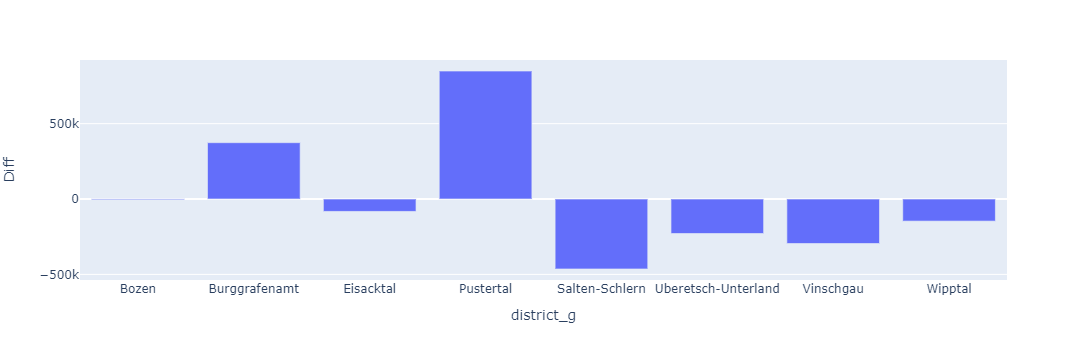

In [125]:
fig = px.bar(visualizeOverallMap, x='district_g', y='Diff')
fig.show()

#### By District and Time

In [28]:
visualizeTime = arrivals2

## FILTER BY NAT
# visualizeOverall = visualizeOverall[visualizeOverall['Nationality'] == 'Germany']

visualizeTime["Day"] = 1
visualizeTime["Date"] = pd.to_datetime(visualizeTime[['Year', 'Month', 'Day']])

visualizeTime = visualizeTime.groupby(["District", "Date"]).sum().reset_index()

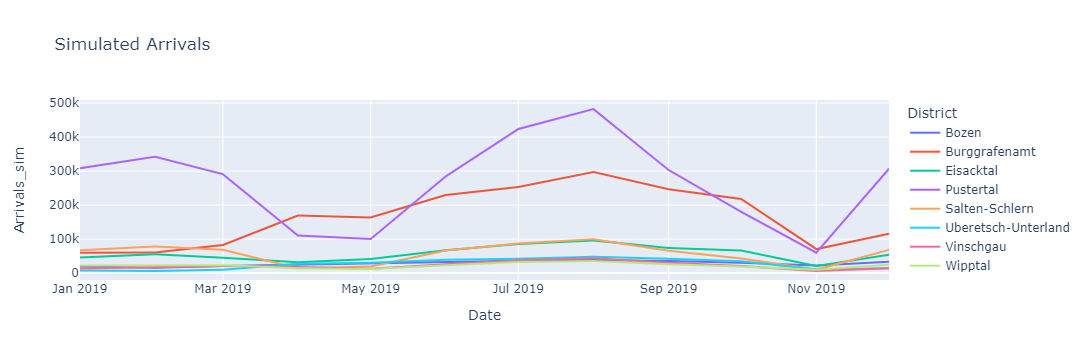

In [29]:
figTime = px.line(visualizeTime, x='Date', y='Arrivals_sim', color='District', title='Simulated Arrivals')
figTime.show()

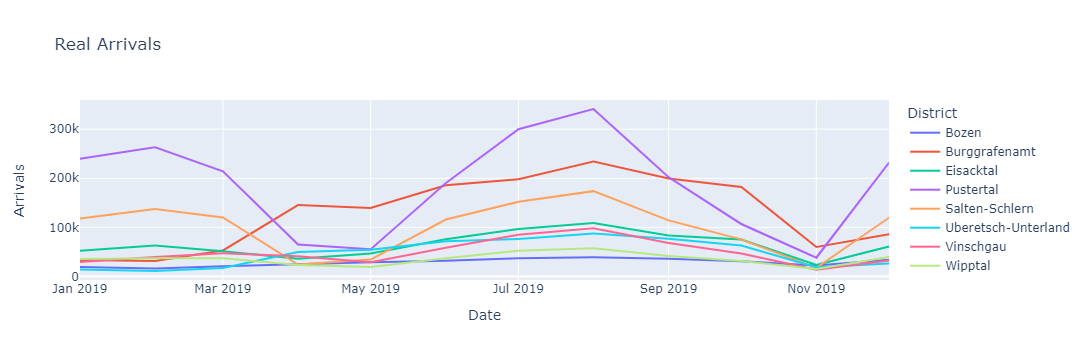

In [30]:
figTimeReal = px.line(visualizeTime, x='Date', y='Arrivals', color='District', title='Real Arrivals')
figTimeReal.show()